<a href="https://colab.research.google.com/github/Codehackerone/VisionTransformers/blob/main/Vision_Transformer_TF2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 36.3 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from tensorflow.keras.callbacks import TensorBoard

In [3]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        #attention takes three inputs: queries, keys, and values,
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        #use the product between the queries and the keys 
        #to know "how much" each element is the sequence is important with the rest
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        #resulting vector, score is divided by a scaling factor based on the size of the embedding
        #scaling fcator is square root of the embeding dimension
        scaled_score = score / tf.math.sqrt(dim_key)
        #the attention scaled_score is then softmaxed
        weights = tf.nn.softmax(scaled_score, axis=-1)
        #Attention(Q, K, V ) = softmax[(QK)/√dim_key]V
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.num_heads, self.projection_dim)
        )
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
         
        batch_size = tf.shape(inputs)[0]
        #MSA takes the queries, keys, and values  as input from the previous layer 
        #and projects them using the three linear layers.
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )
        #self attention of different heads are concatenated  
        output = self.combine_heads(concat_attention)
        return output


In [4]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        # Transfromer block multi-head Self Attention
        self.multiheadselfattention = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training):
        out1 = self.layernorm1(inputs)       
        attention_output = self.multiheadselfattention(out1)
        attention_output = self.dropout1(attention_output, training=training)       
        out2 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [5]:
class VisionTransformer(tf.keras.Model):
    def __init__(
        self,
        image_size,
        patch_size,
        num_layers,
        num_classes,
        d_model,
        num_heads,
        mlp_dim,
        channels=3,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        # create patches based on patch_size
        # image_size/patch_size==0
        num_patches=self.create_patch(image_size,patch_size, channels)
        self.d_model = d_model
        self.rescale = Rescaling(1./255)
        self.patch_proj= self.create_postional_embedding(num_patches, d_model)
        self.enc_layers = [
            TransformerBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]
        self.mlp_head = tf.keras.Sequential(
            [
                Dense(mlp_dim, activation=tfa.activations.gelu),
                Dropout(dropout),
                Dense(num_classes),
            ]
        )

    def create_patch(self, image_size, patch_size, channels):
        num_patches = (image_size // patch_size) ** 2
        self.patch_dim = channels * patch_size ** 2
        self.patch_size = patch_size
        return num_patches
    def create_postional_embedding(self,num_patches, d_model):
        self.pos_emb = self.add_weight("pos_emb", shape=(1, num_patches + 1, d_model))
        self.class_emb = self.add_weight("class_emb", shape=(1, 1, d_model))
        print(self.class_emb.shape)
        return Dense(d_model)
   
        
    def extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_dim])
        return patches

    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        #rescale 
        x = self.rescale(x)
        # extract the patches from the image
        patches = self.extract_patches(x)
        # Apply the postio embedding
        x = self.patch_proj(patches)        
        class_emb = tf.broadcast_to(
            self.class_emb, [batch_size, 1, self.d_model]
        )              
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb        
        for layer in self.enc_layers:
            x = layer(x, training)
        x = self.mlp_head(x[:, 0])
        return x

In [10]:
model = None


AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE=32
PATCH_SIZE=4 
NUM_LAYERS=8
NUM_HEADS=16
MLP_DIM=128
lr=0.001
WEIGHT_DECAY=1e-4
BATCH_SIZE=64
epochs=30

ds, info = tfds.load("cifar10", as_supervised=True, with_info=True)
ds_train = (
    ds["train"]
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
ds_test = (
    ds["test"]
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


model = VisionTransformer(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=10,
    d_model=64,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM,
    channels=3,
    dropout=0.1,
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=WEIGHT_DECAY),
    metrics=["accuracy"],
)

early_stop = tf.keras.callbacks.EarlyStopping(patience=10),
mcp = tf.keras.callbacks.ModelCheckpoint(filepath='weights/best.tf', 
                                         save_best_only=True, 
                                         monitor='val_loss', 
                                         mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.1, 
                                                 patience=3, 
                                                 verbose=0, 
                                                 mode='auto',
min_delta=0.0001, cooldown=0, min_lr=0)    

model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=epochs,
    callbacks=[early_stop, mcp, reduce_lr],
)
model.save_weights(os.path.join('.', "vit"))

(1, 1, 64)
Epoch 1/30
781/782 [============================>.] - ETA: 0s - loss: 2.3108 - accuracy: 0.1035

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 89s 95ms/step - loss: 2.3108 - accuracy: 0.1035 - val_loss: 2.3044 - val_accuracy: 0.1001 - lr: 0.0010
Epoch 2/30
782/782 [==============================] - 49s 63ms/step - loss: 2.3063 - accuracy: 0.1010 - val_loss: 2.3044 - val_accuracy: 0.1001 - lr: 0.0010
Epoch 3/30
781/782 [============================>.] - ETA: 0s - loss: 2.3059 - accuracy: 0.1009

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 66s 84ms/step - loss: 2.3059 - accuracy: 0.1009 - val_loss: 2.3042 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/30
781/782 [============================>.] - ETA: 0s - loss: 2.3050 - accuracy: 0.0997

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 66s 85ms/step - loss: 2.3050 - accuracy: 0.0997 - val_loss: 2.3040 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/30
781/782 [============================>.] - ETA: 0s - loss: 2.3047 - accuracy: 0.0983

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 84ms/step - loss: 2.3047 - accuracy: 0.0983 - val_loss: 2.3037 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/30
781/782 [============================>.] - ETA: 0s - loss: 2.3048 - accuracy: 0.0980

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 66s 84ms/step - loss: 2.3048 - accuracy: 0.0980 - val_loss: 2.3037 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 7/30
781/782 [============================>.] - ETA: 0s - loss: 2.3041 - accuracy: 0.1001

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 84ms/step - loss: 2.3041 - accuracy: 0.1001 - val_loss: 2.3034 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 8/30
781/782 [============================>.] - ETA: 0s - loss: 2.3037 - accuracy: 0.1002

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 66s 85ms/step - loss: 2.3037 - accuracy: 0.1001 - val_loss: 2.3033 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 9/30
782/782 [==============================] - 47s 60ms/step - loss: 2.3034 - accuracy: 0.0990 - val_loss: 2.3034 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 10/30
781/782 [============================>.] - ETA: 0s - loss: 2.3034 - accuracy: 0.0998

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 84ms/step - loss: 2.3034 - accuracy: 0.0998 - val_loss: 2.3030 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 11/30
781/782 [============================>.] - ETA: 0s - loss: 2.3032 - accuracy: 0.1000

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 66s 84ms/step - loss: 2.3032 - accuracy: 0.1000 - val_loss: 2.3028 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 12/30
781/782 [============================>.] - ETA: 0s - loss: 2.3030 - accuracy: 0.0995

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 84ms/step - loss: 2.3030 - accuracy: 0.0994 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 13/30
782/782 [==============================] - 47s 60ms/step - loss: 2.3030 - accuracy: 0.0982 - val_loss: 2.3028 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 14/30
782/782 [==============================] - 47s 60ms/step - loss: 2.3029 - accuracy: 0.0990 - val_loss: 2.3029 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 15/30
781/782 [============================>.] - ETA: 0s - loss: 2.2913 - accuracy: 0.1095

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 84ms/step - loss: 2.2913 - accuracy: 0.1094 - val_loss: 2.2300 - val_accuracy: 0.1802 - lr: 1.0000e-04
Epoch 16/30
781/782 [============================>.] - ETA: 0s - loss: 2.1113 - accuracy: 0.1902

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 84ms/step - loss: 2.1112 - accuracy: 0.1902 - val_loss: 2.0085 - val_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 17/30
781/782 [============================>.] - ETA: 0s - loss: 1.9591 - accuracy: 0.2162

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 66s 84ms/step - loss: 1.9591 - accuracy: 0.2162 - val_loss: 1.9045 - val_accuracy: 0.2314 - lr: 1.0000e-04
Epoch 18/30
781/782 [============================>.] - ETA: 0s - loss: 1.8959 - accuracy: 0.2353

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 66s 84ms/step - loss: 1.8958 - accuracy: 0.2353 - val_loss: 1.8607 - val_accuracy: 0.2356 - lr: 1.0000e-04
Epoch 19/30
781/782 [============================>.] - ETA: 0s - loss: 1.8486 - accuracy: 0.2579

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 84ms/step - loss: 1.8486 - accuracy: 0.2580 - val_loss: 1.8058 - val_accuracy: 0.2785 - lr: 1.0000e-04
Epoch 20/30
782/782 [==============================] - 47s 60ms/step - loss: 1.8189 - accuracy: 0.2803 - val_loss: 1.8078 - val_accuracy: 0.2867 - lr: 1.0000e-04
Epoch 21/30
781/782 [============================>.] - ETA: 0s - loss: 1.7893 - accuracy: 0.3064

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 83ms/step - loss: 1.7892 - accuracy: 0.3064 - val_loss: 1.7441 - val_accuracy: 0.3259 - lr: 1.0000e-04
Epoch 22/30
781/782 [============================>.] - ETA: 0s - loss: 1.7569 - accuracy: 0.3233

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 83ms/step - loss: 1.7569 - accuracy: 0.3233 - val_loss: 1.7090 - val_accuracy: 0.3427 - lr: 1.0000e-04
Epoch 23/30
781/782 [============================>.] - ETA: 0s - loss: 1.7278 - accuracy: 0.3363

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 84ms/step - loss: 1.7278 - accuracy: 0.3363 - val_loss: 1.6917 - val_accuracy: 0.3484 - lr: 1.0000e-04
Epoch 24/30
781/782 [============================>.] - ETA: 0s - loss: 1.7064 - accuracy: 0.3457

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 83ms/step - loss: 1.7064 - accuracy: 0.3457 - val_loss: 1.6862 - val_accuracy: 0.3482 - lr: 1.0000e-04
Epoch 25/30
781/782 [============================>.] - ETA: 0s - loss: 1.6840 - accuracy: 0.3531

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 83ms/step - loss: 1.6840 - accuracy: 0.3531 - val_loss: 1.6482 - val_accuracy: 0.3673 - lr: 1.0000e-04
Epoch 26/30
781/782 [============================>.] - ETA: 0s - loss: 1.6647 - accuracy: 0.3590

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 83ms/step - loss: 1.6647 - accuracy: 0.3590 - val_loss: 1.6221 - val_accuracy: 0.3778 - lr: 1.0000e-04
Epoch 27/30
781/782 [============================>.] - ETA: 0s - loss: 1.6531 - accuracy: 0.3624

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 83ms/step - loss: 1.6531 - accuracy: 0.3623 - val_loss: 1.6175 - val_accuracy: 0.3829 - lr: 1.0000e-04
Epoch 28/30
781/782 [============================>.] - ETA: 0s - loss: 1.6371 - accuracy: 0.3715

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 83ms/step - loss: 1.6371 - accuracy: 0.3715 - val_loss: 1.5987 - val_accuracy: 0.3785 - lr: 1.0000e-04
Epoch 29/30
781/782 [============================>.] - ETA: 0s - loss: 1.6268 - accuracy: 0.3772

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 83ms/step - loss: 1.6269 - accuracy: 0.3772 - val_loss: 1.5859 - val_accuracy: 0.3926 - lr: 1.0000e-04
Epoch 30/30
781/782 [============================>.] - ETA: 0s - loss: 1.6206 - accuracy: 0.3794

INFO:tensorflow:Assets written to: weights/best.tf/assets


INFO:tensorflow:Assets written to: weights/best.tf/assets


782/782 [==============================] - 65s 83ms/step - loss: 1.6205 - accuracy: 0.3794 - val_loss: 1.5778 - val_accuracy: 0.3942 - lr: 1.0000e-04


In [11]:
model.summary()

Model: "vision_transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 dense_51 (Dense)            multiple                  3136      
                                                                 
 transformer_block_8 (Transf  multiple                 33472     
 ormerBlock)                                                     
                                                                 
 transformer_block_9 (Transf  multiple                 33472     
 ormerBlock)                                                     
                                                                 
 transformer_block_10 (Trans  multiple                 33472     
 formerBlock)                                                    
                                              

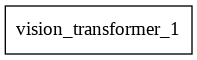

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
#plot_model(model, to_file='model.png')

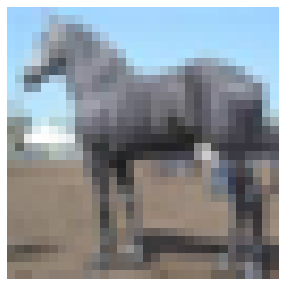

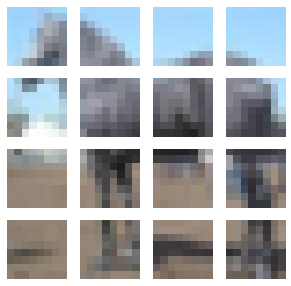

In [13]:
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
import cv2


AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE=32
PATCH_SIZE=8 
NUM_LAYERS=8
NUM_HEADS=16
MLP_DIM=128
lr=1e-3
WEIGHT_DECAY=1e-4
BATCH_SIZE=64
num_patches=IMAGE_SIZE//PATCH_SIZE
epochs=1
ds = tfds.load("cifar10", as_supervised=True)
ds_train = (
    ds["train"]
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
plt.figure(figsize=(5, 5))

for images, labels in ds_train.take(1):
  for i in range(1):
    #ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    
    plt.axis("off")
patches = tf.image.extract_patches(
            images=images[:1],
            sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
            strides=[1, PATCH_SIZE, PATCH_SIZE, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

plt.figure(figsize=(5, 5))

for imgs in patches:
    count = 0
    for r in range(num_patches):
        for c in range(num_patches):
            ax = plt.subplot(num_patches, num_patches, count+1)
            plt.imshow(tf.reshape(imgs[r,c],shape=(PATCH_SIZE,PATCH_SIZE,3)).numpy().astype("uint8"))
            plt.axis("off")
            count += 1



In [14]:
for image, target in ds_test.take(1):
  y = model.predict(image)
  print(np.argmax(y, axis=1), target)

[5 1 6 8 7 9 5 0 2 2 7 4 0 1 6 0 8 8 5 1 4 6 5 4 7 8 4 8 1 8 6 0 7 4 2 0 6
 1 8 8 1 5 8 5 6 9 2 8 5 6 5 5 1 0 4 6 1 4 5 8 5 4 4 1] tf.Tensor(
[7 0 6 9 5 1 7 0 3 2 7 2 7 9 6 8 8 8 7 9 4 2 3 5 0 0 2 8 1 8 2 0 7 2 0 0 9
 1 0 5 1 5 0 3 5 0 2 0 5 3 7 4 1 4 2 5 1 5 2 0 7 2 2 1], shape=(64,), dtype=int64)
